### Lecture 3: Onset and beat detection with Essentia

In this example, we demonstrate use of onset detection functions (using HFC and complex spectral difference) and a beat-tracker available in Essentia. 


In [1]:
import os
from essentia.standard import *
from essentia import Pool, array
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [2]:
#Assuming you have run the previous notebook and downloaded some files
soundsDir='../data/onset/'
wavFileNames=['25-rujero.wav','RM-C036.wav','3-you_think_too_muchb.wav','tiersen11.wav']
fs = 44100
durInSecs=5
t=np.arange(durInSecs*fs)/float(fs)
zero_array=t*0#used only for plotting purposes
windowSize=1024
hopSize=256

#Loading Essentia functions required
# See Essenatia tutorial example: 
# https://github.com/MTG/essentia/blob/master/src/examples/tutorial/example_onsetdetection.py
od_hfc = OnsetDetection(method='hfc')
od_complex = OnsetDetection(method='complex')
w = Windowing(type = 'hann')
fft = FFT() # this gives us a complex FFT
c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
onsets = Onsets()

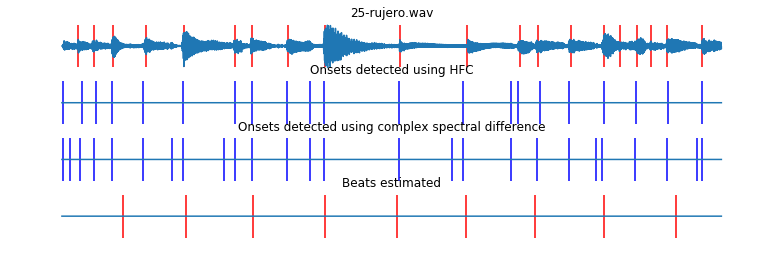

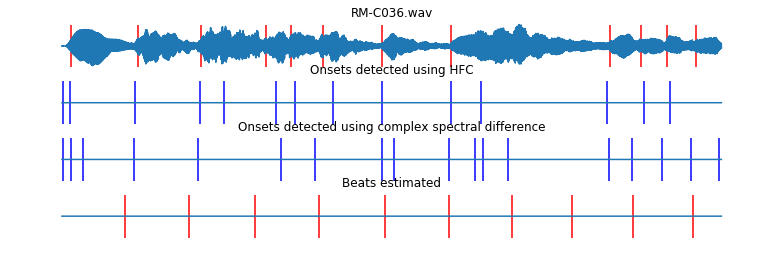

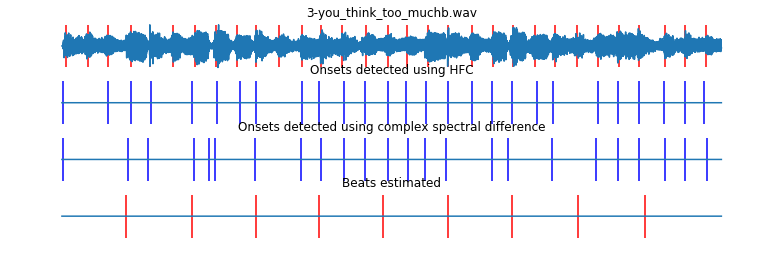

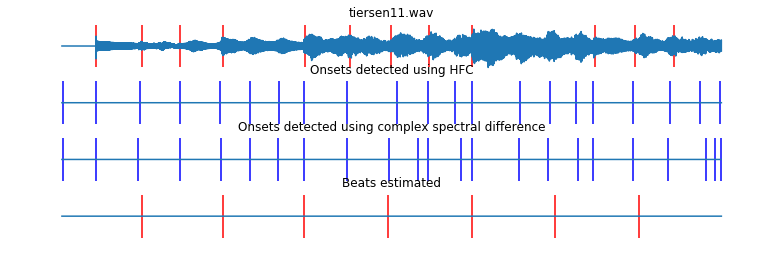

In [3]:
ind=0
for file in wavFileNames:
    fileName = os.path.join(soundsDir, file)
    x = MonoLoader(filename = fileName, sampleRate = fs)()
    x = x[:durInSecs*fs]#let's use only the first two seconds of the signals
    x = x/np.max(np.abs(x))
    #reading ground-truth annotation
    true_onsets=np.loadtxt(fileName.replace('.wav','.txt'))
    true_onsets=true_onsets[true_onsets<durInSecs]
    
    #Plotting
    f, axarr = plt.subplots(4,1,figsize=(13, 4))
    axarr[0].plot(t,x);axarr[0].set_title(file);axarr[0].axis('off')
    axarr[0].vlines(true_onsets, -1, 1, color='r')
    
    #Essentia beat tracking
    pool = Pool()
    for frame in FrameGenerator(x, frameSize = 1024, hopSize = 512):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features.hfc', od_hfc(mag, phase))
        pool.add('features.complex', od_complex(mag, phase))
    
    onsets_hfc = onsets(array([pool['features.hfc']]),[1])
    #onsets_hfc = onsets_hfc[onsets_hfc<durInSecs]
    
    onsets_complex = onsets(array([pool['features.complex']]), [1])
    #onsets_complex = onsets_complex[onsets_complex<durInSecs]
    
    #Plotting onsets computed by essentia 
    axarr[1].plot(t,zero_array);axarr[1].set_title('Onsets detected using HFC');
    axarr[1].axis('off')
    axarr[1].vlines(onsets_hfc, -1, 1, color='b')
    
    axarr[2].plot(t,zero_array);axarr[2].set_title('Onsets detected using complex spectral difference');
    axarr[2].axis('off')
    axarr[2].vlines(onsets_complex, -1, 1, color='b')
    
    #Beat tracking
    beatTracker = BeatTrackerDegara()#Essentia-bug: reset function fails, so re-created
    ticks = beatTracker(x)
    
    axarr[3].plot(t,zero_array);axarr[3].set_title('Beats estimated');
    axarr[3].axis('off')
    axarr[3].vlines(ticks, -1, 1, color='r')
    
    ind=ind+1